In [ ]:
# Colab setup (safe to skip locally)
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Core deps for Planetoid + PyG
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'scipy'])
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'torch-geometric'])


# Experiment: GNN Failure Risk Audit

Objective:
- Test whether graph-structural signals predict GNN failure (generalisation error).
- Compare MLP vs GCN vs GraphSAGE vs GAT across graph families.

Success criteria:
- Produce performance vs homophily plots and a risk-structure correlation table.


In [1]:
# Setup: imports and reproducibility
from __future__ import annotations

import math
import os
import random

# Ensure matplotlib can write cache (use /tmp in restricted envs)
os.environ.setdefault('MPLCONFIGDIR', '/tmp')

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)


/Users/matthew/Desktop/OrgApplications/MASTERS/Cam/Courses/GeometricDL/GDL/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plan

Hypothesis:
- GNN generalisation degrades as alignment between graph structure and labels weakens.

Variables to sweep:
- Homophily/heterophily (via SBM parameters)
- Graph size / degree regime
- Eigenvalue structure (approx. via SBM settings)

Metrics:
- Accuracy (train/val/test)
- Generalisation gap
- Correlation with structural risk signals


In [2]:
# Configuration (small sweep)
CONFIG = {
    "num_graphs_per_setting": 3,
    "num_nodes": [200, 400],
    "feature_dim": 16,
    "num_classes": 2,
    "sbm_settings": [
        # (p_in, p_out) controls homophily
        (0.10, 0.01),
        (0.07, 0.03),
        (0.03, 0.05),
    ],
    "train_ratio": 0.6,
    "val_ratio": 0.2,
    "epochs": 30,
    "lr": 1e-3,
    "hidden_dim": 32,
}


## Data: Graph Families
We generate synthetic SBM graphs to control homophily/heterophily. Labels are tied to SBM communities, and we compute structural signals per graph.


In [3]:
# Synthetic graph generation (SBM)

def generate_sbm_graph(num_nodes, num_classes, p_in, p_out, feature_dim, seed):
    rng = np.random.default_rng(seed)
    sizes = [num_nodes // num_classes for _ in range(num_classes)]
    sizes[0] += num_nodes - sum(sizes)
    probs = [[p_in if i == j else p_out for j in range(num_classes)] for i in range(num_classes)]

    G = nx.stochastic_block_model(sizes, probs, seed=seed)
    labels = []
    for c, size in enumerate(sizes):
        labels.extend([c] * size)
    labels = np.array(labels)

    # Features: random + weak label signal (can be adjusted later)
    features = rng.normal(size=(num_nodes, feature_dim)).astype(np.float32)
    features += 0.1 * rng.normal(size=(num_nodes, feature_dim)).astype(np.float32) * labels[:, None]

    data = from_networkx(G)
    data.x = torch.tensor(features, dtype=torch.float)
    data.y = torch.tensor(labels, dtype=torch.long)
    return data


## Structural Risk Signals
We compute lightweight proxies: homophily ratio and spectral gap (approx.).


In [4]:
# Structural signals

def homophily_ratio(edge_index, labels):
    src, dst = edge_index
    same = (labels[src] == labels[dst]).float()
    return same.mean().item() if same.numel() > 0 else 0.0


def spectral_gap_approx(data, k=6):
    # Placeholder: use normalized Laplacian eigenvalues (small k)
    # TODO: refine if needed
    import torch_geometric.utils as tg_utils
    L = tg_utils.get_laplacian(data.edge_index, normalization='sym')
    # This returns edge_index, edge_weight of Laplacian; converting to dense for small graphs only
    n = data.num_nodes
    dense = torch.zeros((n, n))
    dense[L[0][0], L[0][1]] = L[1]
    # Compute a few smallest eigenvalues
    vals = torch.linalg.eigvalsh(dense).cpu().numpy()
    vals = np.sort(vals)
    if len(vals) >= 2:
        return float(vals[1] - vals[0])
    return 0.0


## Models
Baseline MLP vs GCN / GraphSAGE / GAT.


In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x, edge_index=None):
        return self.net(x)


class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x


## Training and Evaluation


In [6]:
# Train/val/test split

def split_masks(num_nodes, train_ratio=0.6, val_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(num_nodes)
    n_train = int(train_ratio * num_nodes)
    n_val = int(val_ratio * num_nodes)
    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train + n_val]
    test_idx = idx[n_train + n_val:]

    mask = lambda ids: torch.tensor(ids, dtype=torch.long)
    return mask(train_idx), mask(val_idx), mask(test_idx)


def train_epoch(model, data, train_idx, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_acc(model, data, idx):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=-1)
        acc = (pred[idx] == data.y[idx]).float().mean().item()
    return acc


## Experiment Loop


In [7]:
# Run over graph families and models, collect results

results = []

MODEL_FACTORIES = {
    "MLP": lambda in_dim, hidden_dim, out_dim: MLP(in_dim, hidden_dim, out_dim),
    "GCN": lambda in_dim, hidden_dim, out_dim: GCN(in_dim, hidden_dim, out_dim),
    "GraphSAGE": lambda in_dim, hidden_dim, out_dim: GraphSAGE(in_dim, hidden_dim, out_dim),
    "GAT": lambda in_dim, hidden_dim, out_dim: GAT(in_dim, hidden_dim, out_dim),
}

for num_nodes in CONFIG["num_nodes"]:
    for p_in, p_out in CONFIG["sbm_settings"]:
        for i in range(CONFIG["num_graphs_per_setting"]):
            seed = SEED + i + int(p_in * 1000)
            data = generate_sbm_graph(
                num_nodes=num_nodes,
                num_classes=CONFIG["num_classes"],
                p_in=p_in,
                p_out=p_out,
                feature_dim=CONFIG["feature_dim"],
                seed=seed,
            )
            train_idx, val_idx, test_idx = split_masks(
                data.num_nodes,
                CONFIG["train_ratio"],
                CONFIG["val_ratio"],
                seed=seed,
            )

            h_ratio = homophily_ratio(data.edge_index, data.y)
            s_gap = spectral_gap_approx(data)

            for model_name, factory in MODEL_FACTORIES.items():
                model = factory(data.num_features, CONFIG["hidden_dim"], CONFIG["num_classes"])
                optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
                for _ in range(CONFIG["epochs"]):
                    train_epoch(model, data, train_idx, optimizer)

                train_acc = eval_acc(model, data, train_idx)
                val_acc = eval_acc(model, data, val_idx)
                test_acc = eval_acc(model, data, test_idx)

                results.append({
                    "num_nodes": num_nodes,
                    "p_in": p_in,
                    "p_out": p_out,
                    "graph_seed": seed,
                    "model": model_name,
                    "train_acc": train_acc,
                    "val_acc": val_acc,
                    "test_acc": test_acc,
                    "gen_gap": train_acc - test_acc,
                    "homophily": h_ratio,
                    "spectral_gap": s_gap,
                })


## Results (Planned)
- Plot accuracy vs homophily
- Correlate risk signals with generalisation gap


   num_nodes  p_in  p_out  graph_seed      model  train_acc  val_acc  \
0        200   0.1   0.01         142        MLP   0.675000    0.475   
1        200   0.1   0.01         142        GCN   0.866667    0.800   
2        200   0.1   0.01         142  GraphSAGE   0.825000    0.675   
3        200   0.1   0.01         142        GAT   0.958333    0.900   
4        200   0.1   0.01         143        MLP   0.666667    0.475   

   test_acc   gen_gap  homophily  spectral_gap  
0     0.575  0.100000   0.900369      0.160127  
1     0.675  0.191667   0.900369      0.160127  
2     0.575  0.250000   0.900369      0.160127  
3     0.950  0.008333   0.900369      0.160127  
4     0.500  0.166667   0.893598      0.166065  
Wrote output/experiments/gnn_failure_experiment_log.csv


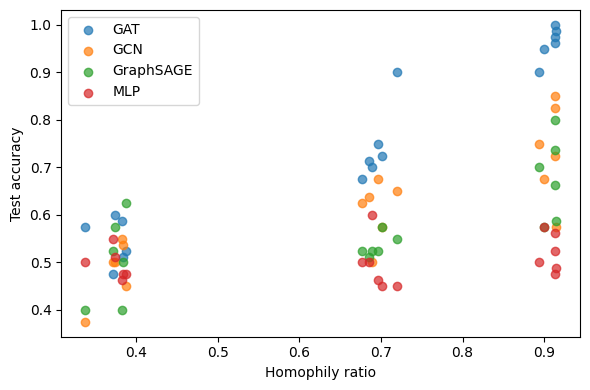

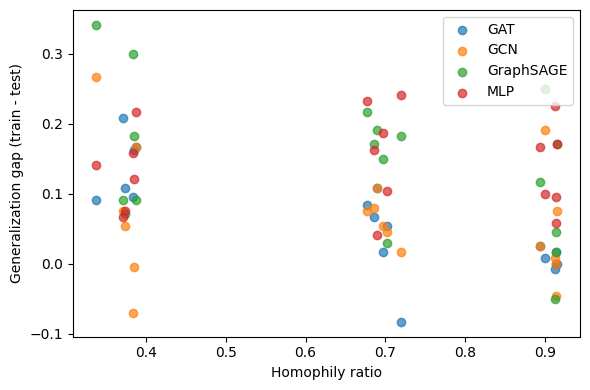

In [8]:
# Analyze and plot
from pathlib import Path

df = pd.DataFrame(results)
print(df.head())

out_path = "output/experiments/gnn_failure_experiment_log.csv"
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)
print(f"Wrote {out_path}")

# Plot: homophily vs test accuracy by model
plt.figure(figsize=(6, 4))
for model, g in df.groupby("model"):
    plt.scatter(g["homophily"], g["test_acc"], label=model, alpha=0.7)
plt.xlabel("Homophily ratio")
plt.ylabel("Test accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("output/experiments/homophily_vs_test_acc.png", dpi=150)

# Plot: homophily vs generalization gap
plt.figure(figsize=(6, 4))
for model, g in df.groupby("model"):
    plt.scatter(g["homophily"], g["gen_gap"], label=model, alpha=0.7)
plt.xlabel("Homophily ratio")
plt.ylabel("Generalization gap (train - test)")
plt.legend()
plt.tight_layout()
plt.savefig("output/experiments/homophily_vs_gen_gap.png", dpi=150)


## Real Datasets (Planetoid)
We repeat the risk analysis on two real-world citation datasets: Cora and CiteSeer.


> Note: Planetoid datasets require local files. If Cora/CiteSeer are not already present under `output/datasets/Planetoid`,
> the cells will skip them. Download the datasets locally and rerun to include real-data results.


In [9]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_undirected

REAL_DATASETS = ["Cora", "CiteSeer"]


In [10]:
# Real dataset helpers
from pathlib import Path

def load_planetoid(name, root="output/datasets/Planetoid"):
    root_path = Path(root) / name
    raw_dir = root_path / "raw"
    processed_dir = root_path / "processed"

    # If running locally without datasets, skip to avoid download failures.
    if not IN_COLAB and not (raw_dir.exists() or processed_dir.exists()):
        print(
            f"[SKIP] {name} not found locally at {root_path}. "
            "Download the Planetoid datasets first (Cora/CiteSeer) and rerun."
        )
        return None

    try:
        dataset = Planetoid(root=root, name=name)
        data = dataset[0]
        data.edge_index = to_undirected(data.edge_index)
        return data
    except Exception as e:
        print(f"[SKIP] Failed to load {name}: {e}")
        return None


def spectral_gap_sparse(data, k=2):
    try:
        edge_index, edge_weight = get_laplacian(data.edge_index, normalization='sym')
        n = data.num_nodes
        L = torch.sparse_coo_tensor(edge_index, edge_weight, (n, n))
        vals, _ = torch.lobpcg(L, k=k, largest=False)
        vals = vals.cpu().numpy()
        vals.sort()
        if len(vals) >= 2:
            return float(vals[1] - vals[0])
    except Exception:
        pass
    return float('nan')


In [11]:
# Run on real datasets
real_results = []

for name in REAL_DATASETS:
    data = load_planetoid(name)
    if data is None:
        continue

    data = data.to(DEVICE)

    # Use standard Planetoid splits
    train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
    val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
    test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)

    h_ratio = homophily_ratio(data.edge_index, data.y)
    s_gap = spectral_gap_sparse(data)

    for model_name, factory in MODEL_FACTORIES.items():
        model = factory(data.num_features, CONFIG["hidden_dim"], int(data.y.max().item()) + 1).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
        for _ in range(CONFIG["epochs"]):
            train_epoch(model, data, train_idx, optimizer)

        train_acc = eval_acc(model, data, train_idx)
        val_acc = eval_acc(model, data, val_idx)
        test_acc = eval_acc(model, data, test_idx)

        real_results.append({
            "dataset": name,
            "model": model_name,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "test_acc": test_acc,
            "gen_gap": train_acc - test_acc,
            "homophily": h_ratio,
            "spectral_gap": s_gap,
        })


[SKIP] Failed to load Cora: No module named 'scipy'
[SKIP] CiteSeer not found locally at output/datasets/Planetoid/CiteSeer. Download the Planetoid datasets first (Cora/CiteSeer) and rerun.


Processing...


In [19]:
# Save and plot real dataset results
from pathlib import Path
real_df = pd.DataFrame(real_results)
real_out = "output/experiments/gnn_failure_real_datasets.csv"
Path(real_out).parent.mkdir(parents=True, exist_ok=True)
real_df.to_csv(real_out, index=False)
print(f"Wrote {real_out}")

plt.figure(figsize=(6, 4))
for model, g in real_df.groupby("model"):
    plt.scatter(g["homophily"], g["test_acc"], label=model, alpha=0.8)
plt.xlabel("Homophily ratio")
plt.ylabel("Test accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("output/experiments/real_homophily_vs_test_acc.png", dpi=150)


OSError: Cannot save file into a non-existent directory: 'output/experiments'

## Next Steps
- Finalize dataset generation grid
- Run the experiment loop
- Record findings in the experiment log


In [ ]:
# Save experiment log (once results exist)
# out_path = "output/experiments/gnn_failure_experiment_log.csv"
# pd.DataFrame(results).to_csv(out_path, index=False)
